In [ ]:
## 기본 라이브러리 호출
import numpy as np
import pandas as pd

## Matplot 호출 및 plotting style 정의 
import matplotlib.pyplot as plt
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['image.cmap'] = 'jet'

# Artificial Neural Networks for Time Series Prediction

Artificial neural networks 는 뇌의 구조를 모사한 컴퓨팅 시스템으로 뇌의 뉴런 간의 커넥션을 학습하는 모델.

## Neural Network Basics

Artificial Neural Networks의 가장 기본 구조인 Perceptron은 입력 matrix $X$를 입력받아 파라미터 $W$를 곱해 weighted sum을 생성하고 여기에 non-linear한 activation function을 적용하여 출력 $y$를 생성함.

Perceptron 은 linear classifier 이므로 XOR과 같은 non-linear를 구분 못함. 그래서 탄생한 것이 multi-layer perceptron.



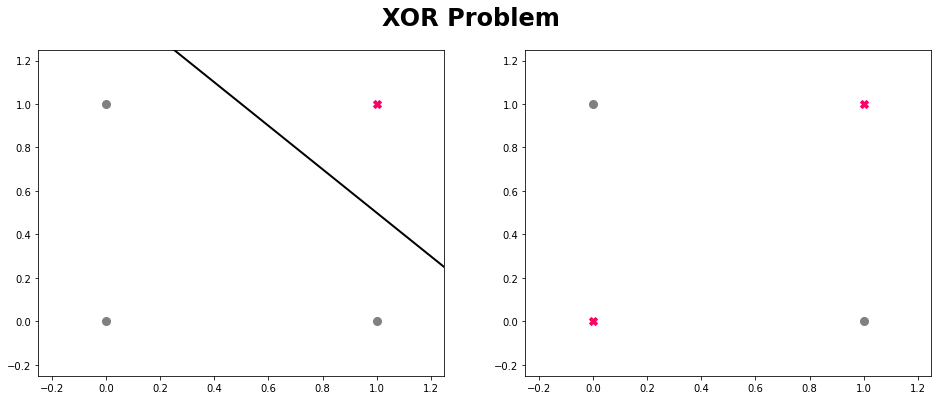

In [ ]:
## Initialize figur and axes
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(16, 6));
fig.suptitle('XOR Problem', fontsize=24, fontweight='bold')

## Classifiable plot
axes[0].plot([0,0,1], [0,1,0], 'o', color='grey')
axes[0].plot([1], [1], 'X', color='#ff0066')
axes[0].plot([0.25, 1.25], [1.25, 0.25], color='black')
axes[0].set_xlim((-0.25, 1.25))
axes[0].set_ylim((-0.25, 1.25))

## Unclassifiable plot
axes[1].plot([0,1], [1,0], 'o', color='grey')
axes[1].plot([0, 1], [0, 1], 'X', color='#ff0066')
axes[1].set_xlim((-0.25, 1.25))
axes[1].set_ylim((-0.25, 1.25))
plt.show()

Multi-layer perceptron 의 출력 $\hat{y}$와 실제 출력 $y$와의 관계를 cost function $E$ 를 사용하여 back-propagation.


Cost function이 neural network의 모든 파라미터에 대해 miminize 되면 cost function이 최소화되는 ($y$와 $\hat{y}$가 비슷해지는) 지점을 찾을 수 있음. 이를 위해 cost function에 대한 weight의 기울기가 앞 레이어까지 back-propagation 됨. 

<strong>Gradient Descent</strong> algorithm

1. initialize with weights $w_{ij}^{(0)}$
2. for s = 1 to S do:
3.     compute $E[w_{ij}^{(s-1)}]$
4.     compute $w_{ij}^{(s)} = w_{ij}^{(s-1)} - \eta \frac{\partial E}{\partial w_{ij}^{(s)}}$   

until $E$ converges to a small value.

## A Supervised Learning Task

Multi-layer perceptron을 시계열 데이터 예측에 사용하기 위해 이전 시각 값을 입력으로, 다음 시각 값을 출력으로 정의한 회귀 분석으로 만들어 주어야 함.

In [ ]:
## 구글 드라이브와 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Set seed
np.random.seed(7)

## Load passenger data set and safe to DataFrame
datapath = '/content/drive/MyDrive/Time Series/international-airline-passengers.csv'
df = pd.read_csv(datapath, header=None, index_col=0)
df = df.rename(columns={1: 'passengers'}) # column 명과
df = df.rename_axis('month') # 인덱스 명 바꿈
df.index = pd.to_datetime(df.index, format='%Y-%m') # 인덱스를 datetime format으로
y = df['passengers'] # New pandas Series

data = df.values
print(data.dtype)

## Data type이 정수형이므로 이를 float로 바꿔줌
data = data.astype('float32')
print(data.dtype)

print(data.shape)
## Slice the data
train = data[0:120, :]   # length 120
test = data[120:, :]     # length 24

int64
float32
(144, 1)


<strong>prepare_data</strong> 함수는 시계열 데이터 예측을 위해 시계열 데이터를 lags 만큼 뒤로 shifting 시켜주는 함수. 이를 통해 회귀 분석으로 시계열 데이터를 예측할 수 있음.

lags=1 이라면 $X$는 $t$ 시점에서의 승객 수, $y$는 $t+1$ 시점에서의 승객 수가 됨.


In [ ]:
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)

In [ ]:
lags = 1
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)
y_true = y_test     ## due to naming convention
print(X_train[:5,:])
print(y_train[:5])

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]]
[118. 132. 129. 121. 135.]


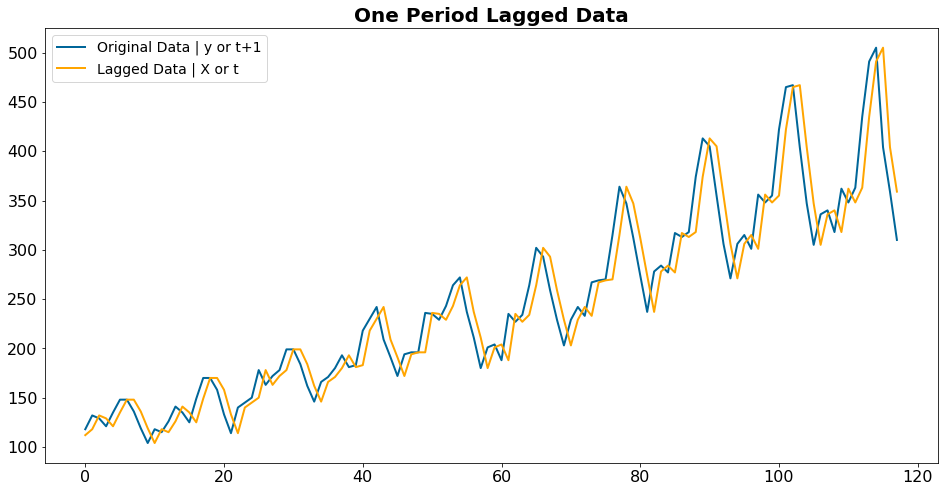

In [ ]:
## plot the created data
plt.plot(y_train, label='Original Data | y or t+1', color='#006699')
plt.plot(X_train, label='Lagged Data | X or t', color='orange')
plt.legend(loc='upper left')
plt.title('One Period Lagged Data')
plt.show()

## Multilayer Perceptron Network

전의 예제와 같이 train set으로 훈련시킨 이후에 test set에 대해 테스트. 

Multi-layer perceptron으로 훈련시킬 경우 lags가 입력 차원이 되고 출력 차원은 1임. 또한 회귀 분석임으로 Mean Squared Error 로 optimize.


In [ ]:
import math

## Deep learning
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import plot_model 

## sklearn functionalities
from sklearn.preprocessing import MinMaxScaler

In [ ]:
## Create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(3, input_dim=lags, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=200, batch_size=2, verbose=1)

In [ ]:
## Estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 818.28 MSE (28.61 RMSE)
Test Score: 2803.60 MSE (52.95 RMSE)


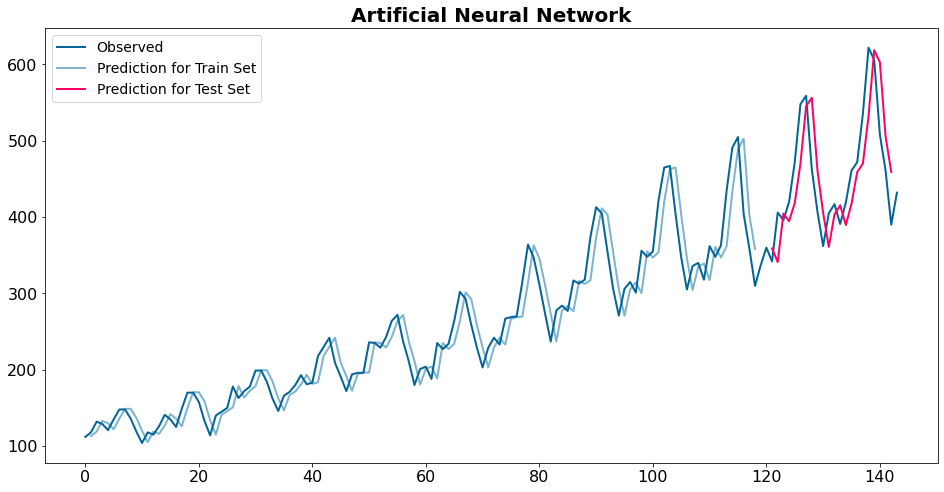

In [ ]:
## Generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

## Shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

## Shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags*2)+1:len(data)-lags, :] = test_predict

## Plot baseline and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='best');
plt.title('Artificial Neural Network')
plt.show()

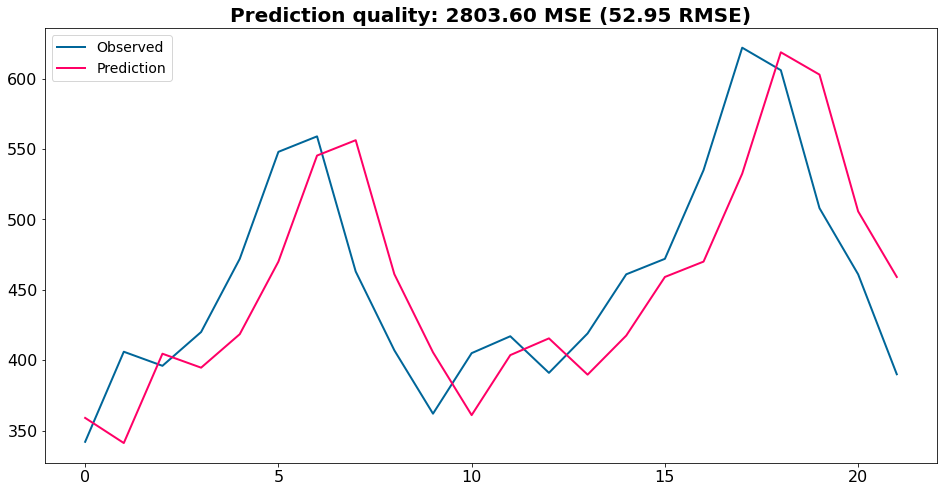

In [ ]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='best')
plt.show()

Neural network가 직전 스텝의 관측치에만 영향을 받으므로 거의 그대로 lags 만큼 shifting 된것을 볼 수 있음.

## Multilayer perceptron with window

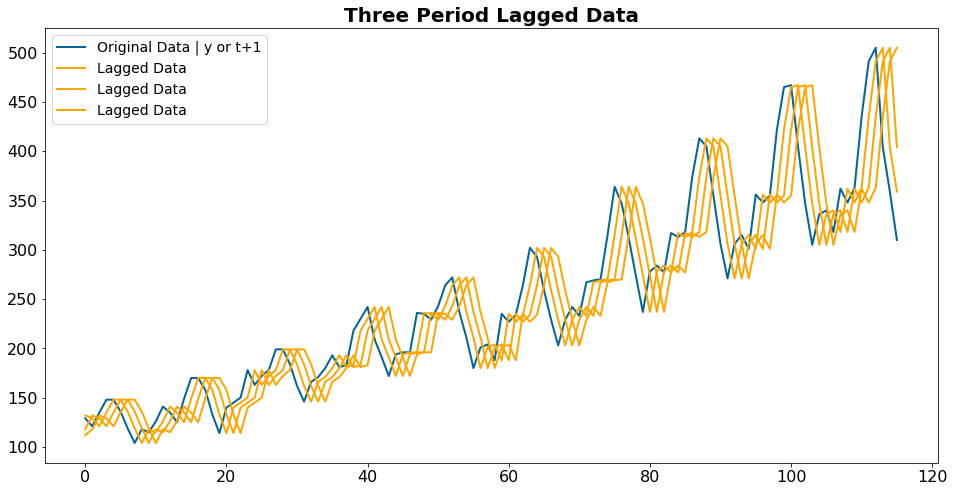

In [ ]:
## Reshape and lag shift the dataset
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

## Plot the created data
plt.plot(y_train, label='Original Data | y or t+1', color='#006699')
plt.plot(X_train, label='Lagged Data', color='orange')
plt.legend(loc='best')
plt.title('Three Period Lagged Data')
plt.show()

In [ ]:
## Create and fit Multilayer Perceptron model
mdl = Sequential()
mdl.add(Dense(4, input_dim=lags, activation='relu'))
mdl.add(Dense(8, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=400, batch_size=2, verbose=1)

In [ ]:
## Estimate model performance
train_score = mdl.evaluate(X_train, y_train, verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(X_test, y_test, verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 741.66 MSE (27.23 RMSE)
Test Score: 2376.75 MSE (48.75 RMSE)


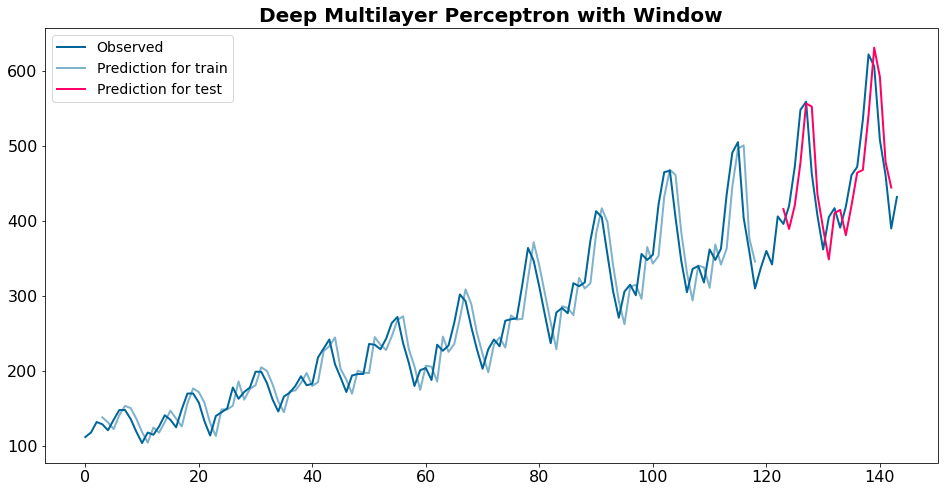

In [ ]:
## Generate predictions for training
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)

## Shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(train_predict) + lags, :] = train_predict

## Shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(lags * 2)+1:len(data)-1, :] = test_predict

## Plot observation and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for train', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for test', color='#ff0066');
plt.legend(loc='best')
plt.title('Deep Multilayer Perceptron with Window')
plt.show()

In [ ]:
y_test

array([396., 420., 472., 548., 559., 463., 407., 362., 405., 417., 391.,
       419., 461., 472., 535., 622., 606., 508., 461., 390.],
      dtype=float32)

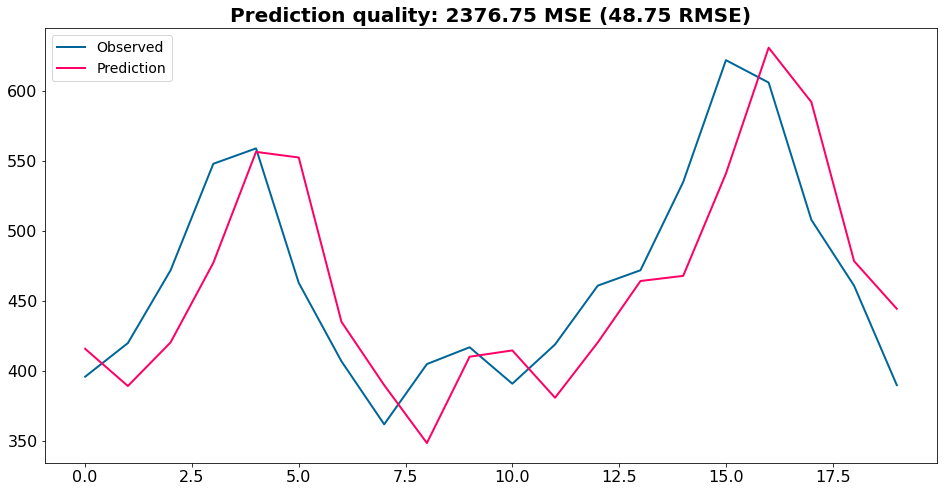

In [ ]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left')
plt.show()

# LSTM Recurrent Neural Network

LSTM은 Recurrent Neural Network 셀 종류의 하나로 시간 속성을 가진 데이터에 대한 모델링이 가능.

## Architecture

LSTM은 시간 스텝 별 정보 흐름을 제어하는 3개의 게이트로 구성. 이 게이트들은 sigmoid가 적용되어 0과 1사이의 값을 내뱉으며 곱셈을 통하여 정보를 어느 정도 허용할 것인지를 결정함.

Input 게이트는 새로운 값을 얼마만큼 들여올 것인지, Forget 게이트는 기존 값에서 얼마만큼의 값을 유지할 것이지, Output 게이트는 새로운 값과 기존 값을 어떻게 조합해서 내보낼 것인지를 결정.


In [ ]:
## Set seed
np.random.seed(1)

## Load passenger data set and safe to DataFrame
datapath = '/content/drive/MyDrive/Time Series/international-airline-passengers.csv'
df = pd.read_csv(datapath, header=None, index_col=0)
df = df.rename(columns={1: 'passengers'}) # column 명과
df = df.rename_axis('month') # 인덱스 명 바꿈
df.index = pd.to_datetime(df.index, format='%Y-%m') # 인덱스를 datetime format으로
y = df['passengers'] # New pandas Series

data = df.values
print(data.dtype)

## Data type이 정수형이므로 이를 float로 바꿔줌
data = data.astype('float32')
print(data.dtype)

## Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

print(data.shape)
## Slice the data
train = dataset[0:120, :]   # length 120
test = dataset[120:, :]     # length 24

# reshape into X=t and Y=t+1
lags = 5
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

int64
float32
(144, 1)
(114, 1, 5) (114,)
(18, 1, 5) (18,)


In [ ]:
## Create and fit the LSTM network
mdl = Sequential()
mdl.add(Dense(6, input_shape=(1, lags), activation='relu'))
mdl.add(LSTM(10, activation='relu'))
mdl.add(Dense(1, activation='relu'))
mdl.compile(loss='mean_squared_error', optimizer='adam')
mdl.fit(X_train, y_train, epochs=100, batch_size=2, verbose=1)

Epoch 1/150
57/57 [==============================] - 1s 1ms/step - loss: 0.1033
Epoch 2/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0434
Epoch 3/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 4/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 5/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 6/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 7/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 8/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0081
Epoch 9/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 10/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 11/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 12/150
57/57 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 13/150
57/57 [=================

In [ ]:
## Make predictions
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
print(train_predict.shape, test_predict.shape)

## Invert transformation
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train]) # [Number of samples, Number of features]
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

## Calculate root mean squared error
train_score = math.sqrt(np.mean((y_train[0] - train_predict[:,0]))**2)
print('Train Score: {:.2f} RMSE'.format(train_score))
test_score = math.sqrt(np.mean((y_test[0] - test_predict[:,0]))**2)
print('Test Score: {:.2f} RMSE'.format(test_score))

(114, 1) (18, 1)
Train Score: 3.45 RMSE
Test Score: 41.67 RMSE


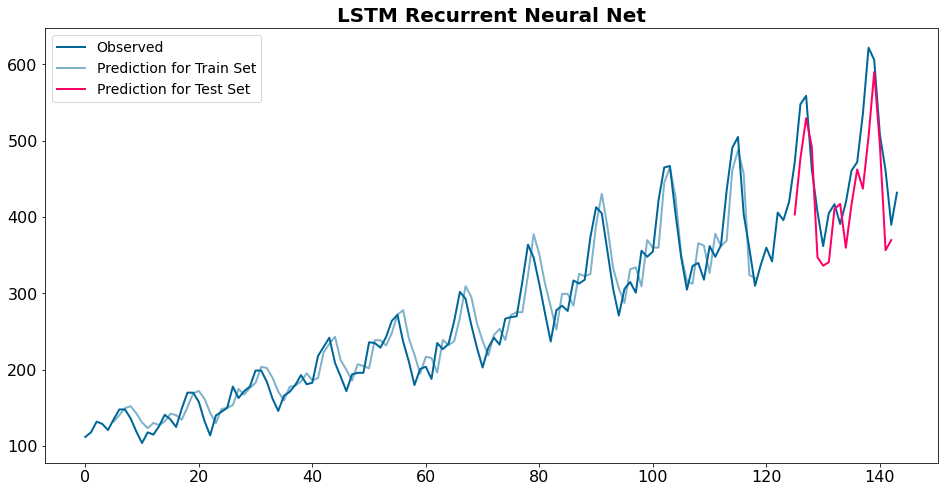

In [ ]:
## Shift train predictions for plotting
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags:len(train_predict)+lags, :] = train_predict

## Shift test predictions for plotting
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (lags * 2)+1:len(data)-1, :] = test_predict

## Plot observation and predictions
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='upper left')
plt.title('LSTM Recurrent Neural Net')
plt.show()

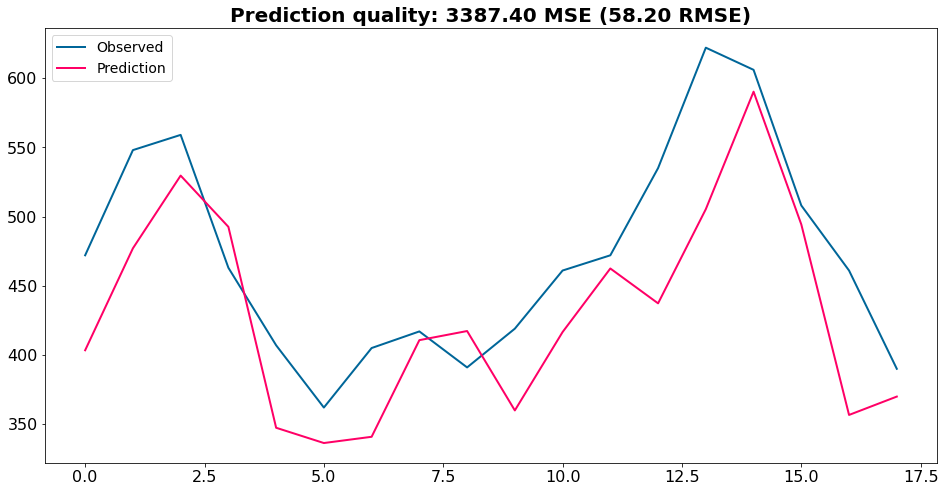

In [ ]:
mse = ((y_test.reshape(-1, 1) - test_predict.reshape(-1, 1)) ** 2).mean()
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left')
plt.show()